# Sample Canon Analysis

In [1]:
import os

from pathlib import Path
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS/CLI-Demos')

In [2]:
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS')

## Select Image & Phantom and Parse

In [3]:
from src.Parsers.canonBinParser import findPreset, getImage

In [4]:
# Inputs
imagePath = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/001/Preset_2/20220427104128_IQ.bin")
phantomPath = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/20220831121752_IQ.bin")

In [5]:
imPreset = findPreset(imagePath)
phantomPreset = findPreset(phantomPath)
assert imPreset == phantomPreset

In [6]:
imgDataStruct, imgInfoStruct, refDataStruct, refInfoStuct = getImage(
    f"{imagePath.name}", f"{imagePath.parent}", f"{phantomPath.name}", f"{phantomPath.parent}"
)

/home/das/QuantUS_Projs/QuantUS/src/Parsers/canonBinParser.py:84: RuntimeWarning: divide by zero encountered in log10
  bmode = 20*np.log10(abs(iq))


Preset 2 found!
Preset 2 found!


## ROI Selection (from GUI)

In [14]:
import pickle

import src.UtcTool2d as UtcTool2d

pkl_name = Path("/media/das/CREST Data/David_S_Data/ATI-Data-CanonFatStudy/Phantom data/Preset_2/test.pkl")

with open(pkl_name, "rb") as f:
    pkl_info = pickle.load(f)

In [15]:
assert pkl_info.imName == imagePath.name
assert pkl_info.phantomName == phantomPath.name

In [16]:
scSplineX = pkl_info.finalSplineX
scSplineY = pkl_info.finalSplineY

## Analysis Config (from GUI)

In [17]:
from pyQus.analysisObjects import Config

In [18]:
config = Config()
config.analysisFreqBand = [pkl_info.lowBandFreq, pkl_info.upBandFreq]
config.axialOverlap = pkl_info.axialOverlap
config.axWinSize = pkl_info.axialWinSize
config.lateralOverlap = pkl_info.lateralOverlap
config.latWinSize = pkl_info.lateralWinSize
config.samplingFrequency = pkl_info.samplingFreq
config.transducerFreqBand = [pkl_info.minFrequency, pkl_info.maxFrequency]
config.windowThresh = pkl_info.threshold/100

## Spectral Analysis

In [19]:
from pyQus.spectral import SpectralAnalysis
from pyQus.analysisObjects import UltrasoundImage

In [20]:
ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.scBmodeStruct.preScArr
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [21]:
spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [22]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

# Visualizations

In [23]:
import matplotlib.pyplot as plt

from src.DataLayer.spectral import SpectralData
from src.DataLayer.dataObjects import ScConfig

In [24]:
scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

In [25]:
spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [26]:
spectralData.convertImagesToRGB()

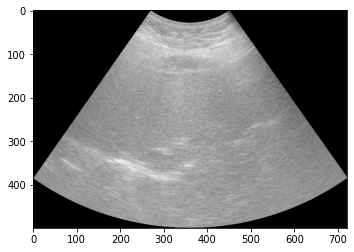

In [27]:
plt.imshow(spectralData.scBmode)

In [28]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

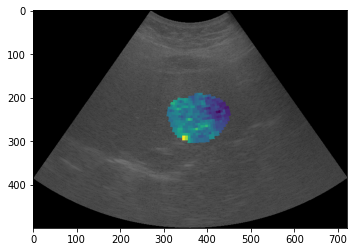

In [29]:
plt.imshow(spectralData.scMbfIm)

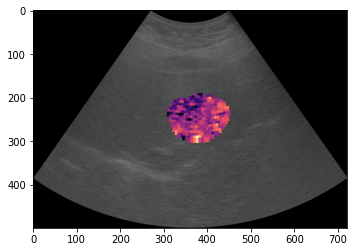

In [30]:
plt.imshow(spectralData.scSsIm)

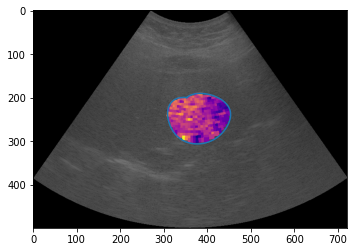

In [31]:
plt.imshow(spectralData.scSiIm)
plt.plot(spectralData.splineX, spectralData.splineY)